In [1]:
import datetime
import time
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from config import get_from_config, save_to_config
from acnet_reader.acnet_reader import fetch_data, get_interpolated_df, fetch_interpolated_data
import fur.path_assistant as path_assistant
import lattice.lattice as lattice
plt.rcParams['figure.figsize'] = [20, 7.5]
plt.rcParams.update({'font.size': 16,'legend.fontsize':16})
shift_03_10_2020 = path_assistant.PathAssistant('shift_03_10_2020')
waveforms_dir = shift_03_10_2020.get_waveforms_dir()
results_dir = shift_03_10_2020.get_results_dir()
acnet_data_dir = shift_03_10_2020.get_acnet_data_dir()
bpm_data_dir = shift_03_10_2020.get_bpm_data_dir()
bpm_files_df = shift_03_10_2020.get_bpm_files_df()
acnet_data_df = shift_03_10_2020.get_acnet_data_df("all_acnet_data_03_10_2020.csv")
fluctuations_df = shift_03_10_2020.get_fluctuations_df("res_df_nd_filters_data_plus_acnet_03_10_2020.csv")
lattice_file = shift_03_10_2020.get_6dsim_dir().fi("IOTA_1NL_100MeV_v8.6.1.3.6ds_data.txt")

In [2]:
lattice_df = lattice.read_lattice_file(lattice_file)

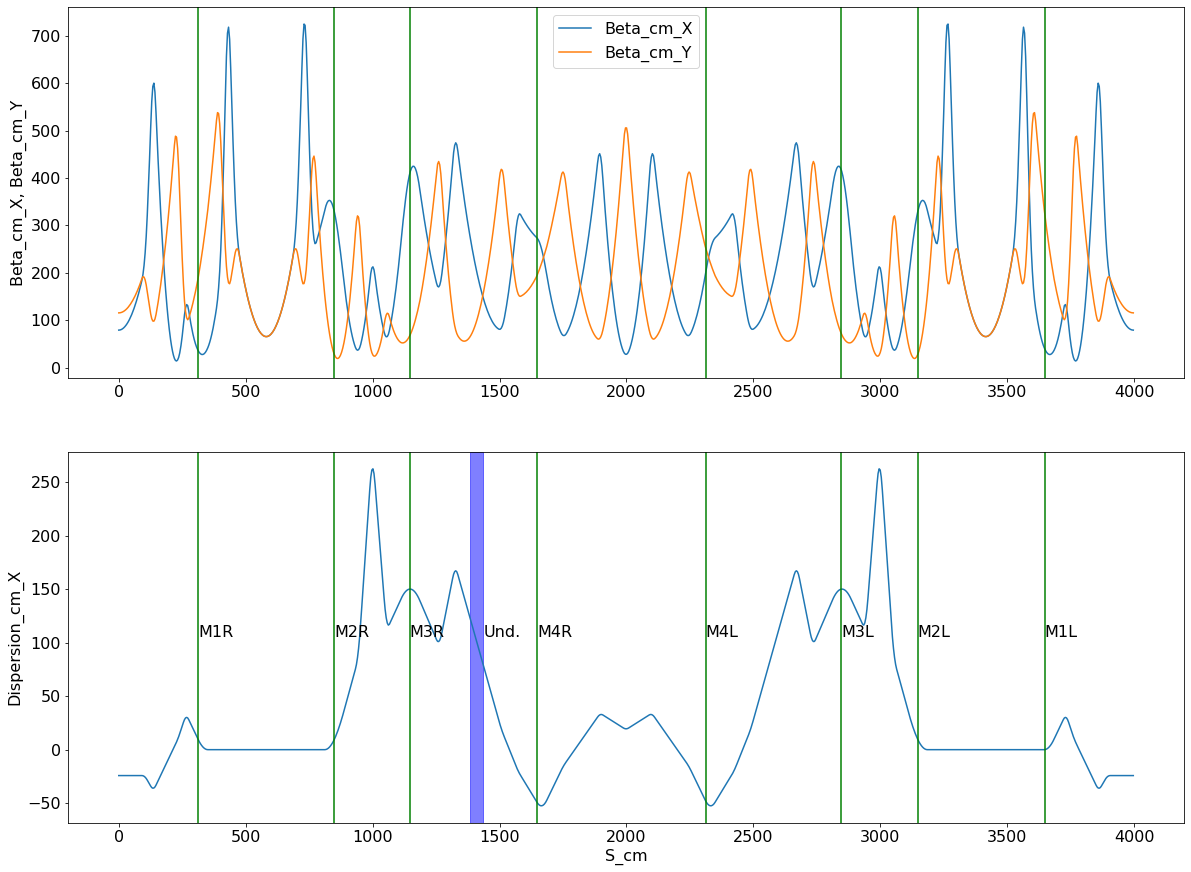

In [3]:
lattice.plot_lattice(lattice_df)

In [4]:
shift_03_10_2020 = path_assistant.PathAssistant('shift_03_10_2020')


In [5]:
cameras_df = lattice.get_cameras_df(
    lattice_df,
    fluctuations_df.loc[:,lattice.acnet_devices_X].mean().values,
    fluctuations_df.loc[:,lattice.acnet_devices_Y].mean().values)
cameras_df


,Name,S_cm,Dispersion_cm_X,Beta_cm_X,Beta_cm_Y,Alpha_X,Alpha_Y,ACNET_device_X,ACNET_device_Y,Measured_sigma_um_X,Measured_sigma_um_Y
0,M1R,312.390772,9.722311,36.225434,188.171560,0.508217,-1.542989,N:ITC1RSH,N:ITC1RSV,482.364166,118.631072
1,M2R,847.531424,8.867605,332.373347,30.217598,1.107789,0.754704,N:ITC2RSH,N:ITC2RSV,1455.804900,82.437101
2,M3R,1146.760637,149.997534,410.057483,67.853144,-1.054932,-0.549460,N:ITC3RSH,N:ITC3RSV,1681.260265,98.769470
3,M4R,1648.557835,-49.483645,272.884031,195.416364,0.304775,-0.662569,N:ITC4RSH,N:ITC4RSV,732.771000,105.998900
4,M4L,2312.048374,-47.892921,200.362880,252.677345,-1.549672,0.927709,N:ITC4LSH,N:ITC4LSV,1104.937873,166.789298
5,M3L,2846.836442,149.983921,415.934446,71.284732,0.832799,0.607294,N:ITC3LSH,N:ITC3LSV,1686.856890,76.189315
6,M2L,3146.927526,9.901680,327.556295,27.031383,-1.229046,-0.642134,N:ITC2LSH,N:ITC2LSV,1594.700080,73.051287
7,M1L,3646.794132,0.035522,40.729689,328.847554,0.616955,2.215497,N:ITC1LSH,N:ITC1LSV,515.091194,141.268839


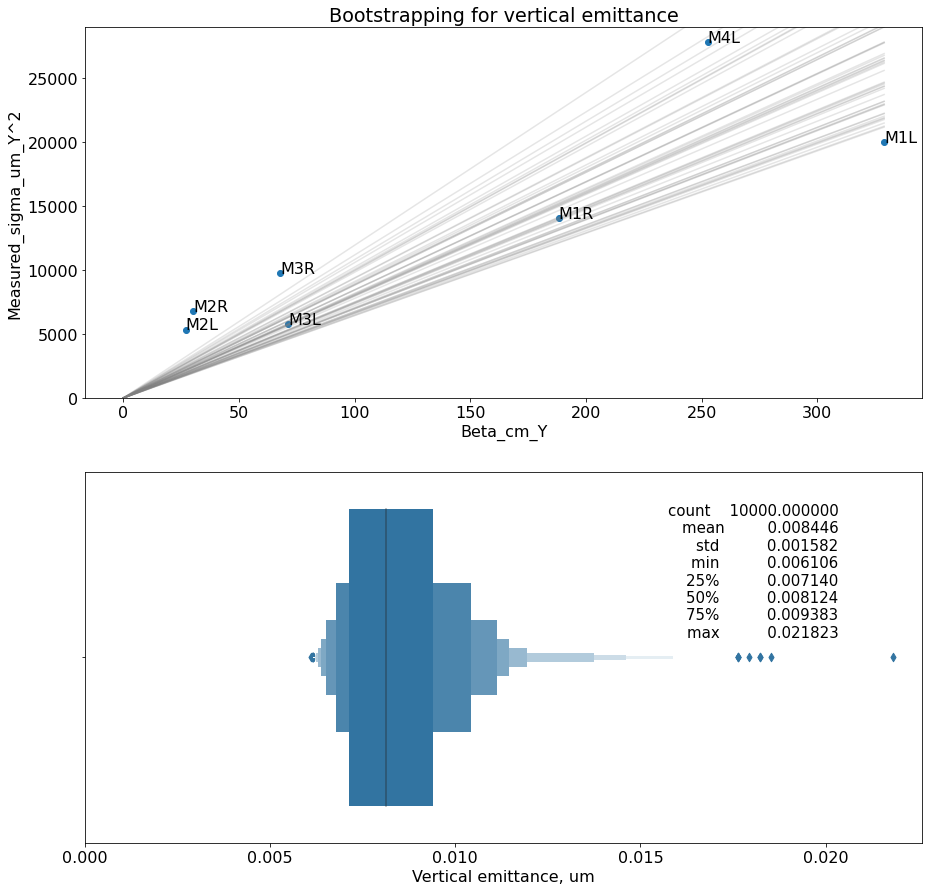

In [6]:
ey_um_description = lattice.get_ey_um_least_squares(cameras_df, show_plot=True)

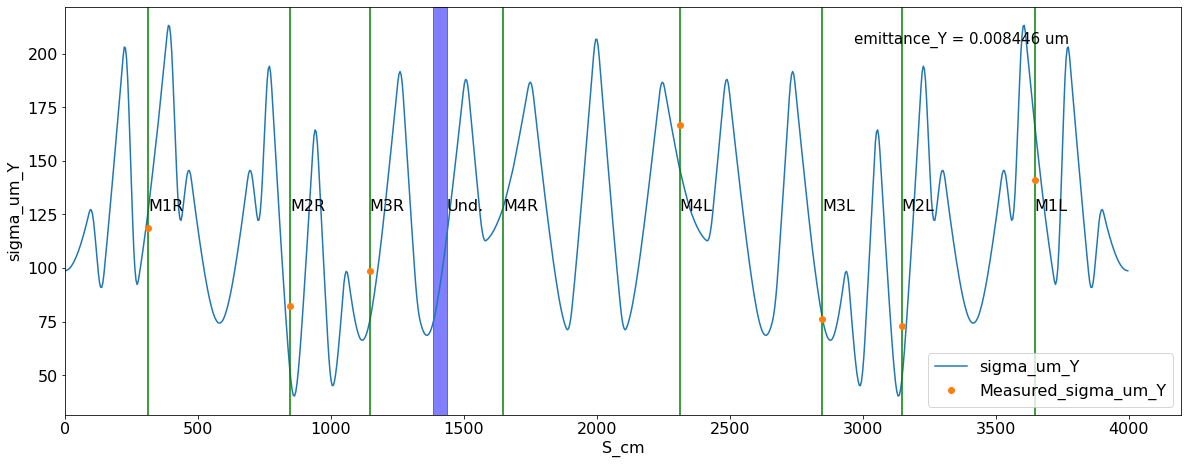

In [7]:
lattice.show_sigma_fit(lattice_df, cameras_df, 'Y', ey_um_description["mean"])

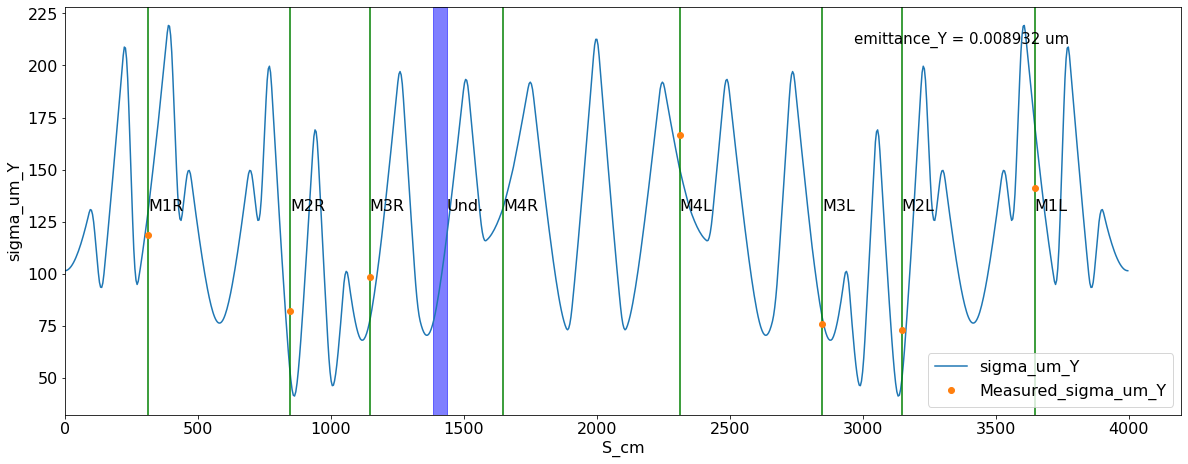

In [8]:
ey_um, ey_err = lattice.get_e_um_Y_scipy_curve_fit(cameras_df)
lattice.show_sigma_fit(lattice_df, cameras_df, 'Y', ey_um)

In [9]:
ey_err/ey_um

0.15856523752941815

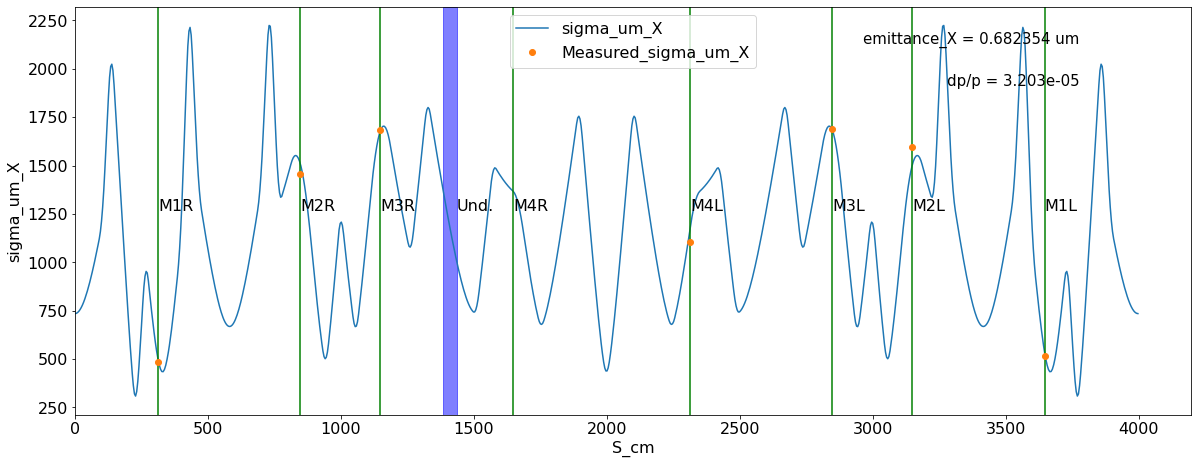

In [10]:
popt, perr = lattice.get_e_um_X_scipy_curve_fit(cameras_df)
ex_um, dpp = popt
ex_err, dpp_err = perr
lattice.show_sigma_fit(lattice_df, cameras_df, 'X', ex_um, dpp=dpp)

In [11]:
ex_err/ex_um

0.04846196317965615

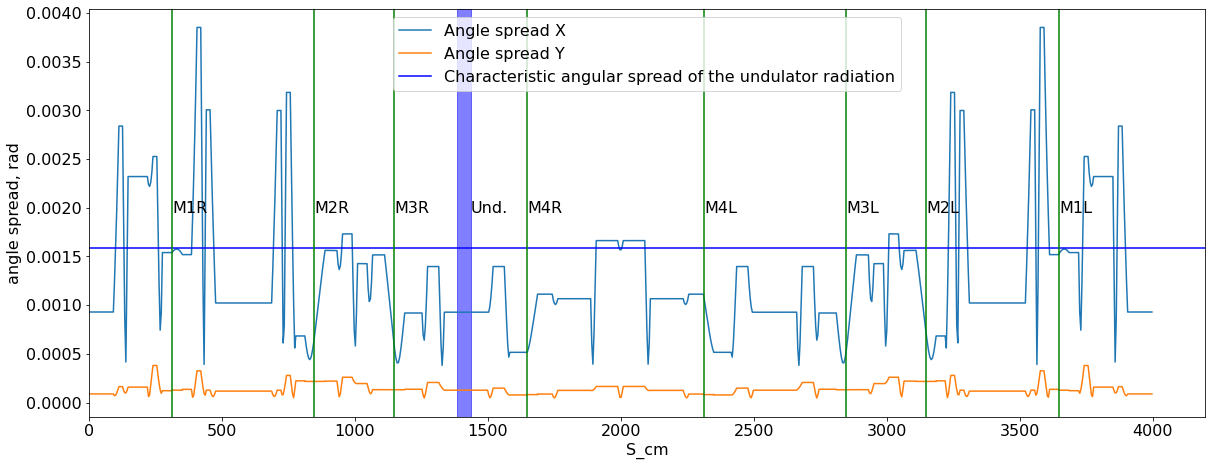

In [12]:
lattice.show_angle_spread_X_Y(lattice_df, ex_um, ey_um)

In [13]:
emmitance_6D = {
        "ex_um": ex_um,
        "ex_err_um": ex_err,
        "ey_um": ey_um,
        "ey_err_um": ey_err,
        "dp/p": dpp,
        "dp/p_err": dpp_err
    }

In [14]:
lattice.get_undulator_df(lattice_df, emmitance_6D)

,S_cm,Dispersion_cm_X,Beta_cm_X,Beta_cm_Y,Alpha_X,Alpha_Y,Sigma_um_X,Sigma_um_X_err,Sigma_um_Y,Sigma_um_Y_err,Angle_spread_rad_X,Angle_spread_rad_Y
Start,1383.90,122.936779,276.365925,65.280075,1.574657,-0.412112,1373.806169,81.794847,76.358295,6.053886,0.000927,0.000127
Middle,1409.65,101.204607,203.630155,98.414182,1.250287,-0.874287,1179.206725,66.870750,93.755066,7.433147,0.000927,0.000127
End,1435.40,79.472435,147.585260,155.330115,0.925917,-1.336463,1003.843267,52.065353,117.786016,9.338384,0.000927,0.000127


In [15]:
from lattice.summary_in_undulator import get_summary_in_undulator

In [16]:
und_summary = get_summary_in_undulator(
    lattice_file,
    fluctuations_df.loc[:,lattice.acnet_devices_X].mean().values,
    fluctuations_df.loc[:,lattice.acnet_devices_Y].mean().values
    )

In [17]:
und_summary[0]

,S_cm,Dispersion_cm_X,Beta_cm_X,Beta_cm_Y,Alpha_X,Alpha_Y,Sigma_um_X,Sigma_um_X_err,Sigma_um_Y,Sigma_um_Y_err,Angle_spread_rad_X,Angle_spread_rad_Y
Start,1383.90,122.936779,276.365925,65.280075,1.574657,-0.412112,1373.806169,81.794847,76.358295,6.053886,0.000927,0.000127
Middle,1409.65,101.204607,203.630155,98.414182,1.250287,-0.874287,1179.206725,66.870750,93.755066,7.433147,0.000927,0.000127
End,1435.40,79.472435,147.585260,155.330115,0.925917,-1.336463,1003.843267,52.065353,117.786016,9.338384,0.000927,0.000127


# Sigma_X error can be made smaller, if I independently estimate dpp and do not fit it here.

In [18]:
und_summary[1]

{'ex_um': 0.6823535935792674,
 'ex_err_um': 0.03306819472754451,
 'ey_um': 0.008931652196730486,
 'ey_err_um': 0.001416249552104719,
 'dp/p': 3.2030482080995725e-05,
 'dp/p_err': 0.0013773367887790623}

In [19]:
und_summary[1].values()

dict_values([0.6823535935792674, 0.03306819472754451, 0.008931652196730486, 0.001416249552104719, 3.2030482080995725e-05, 0.0013773367887790623])